## 1

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [3]:
from IPython.display import Image

## 2

In [2]:
%%sql

SELECT
        name,
        type
  FROM  sqlite_master
 WHERE  type IN ("table","view")

Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


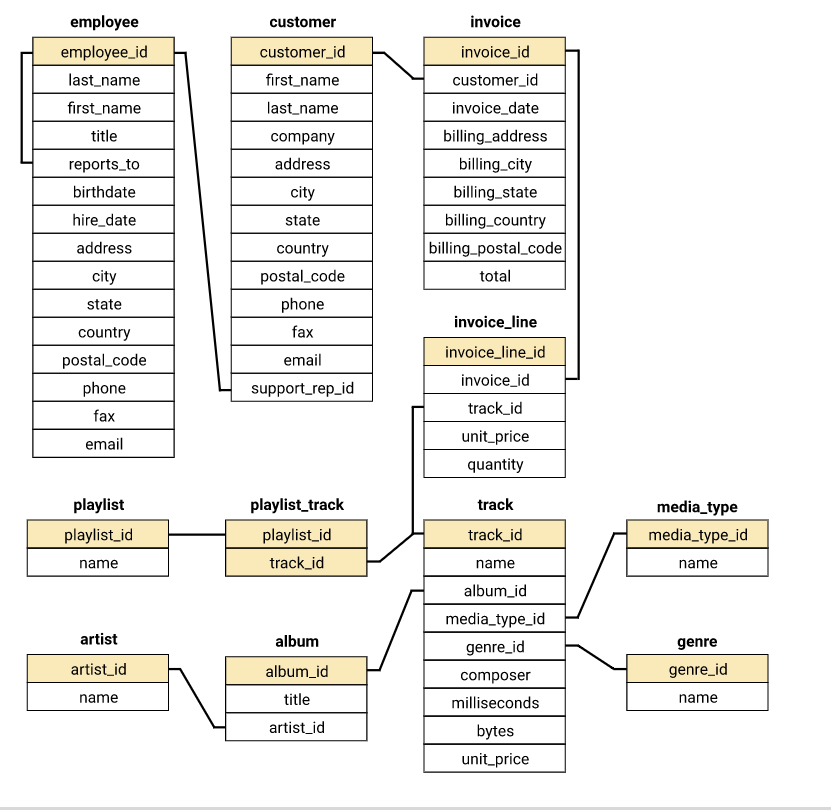

In [4]:
Image('chinook.db schema.PNG')

In [6]:
%%sql
SELECT *
  FROM employee
 LIMIT 3;

Done.


employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
1,Adams,Andrew,General Manager,None,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
2,Edwards,Nancy,Sales Manager,1,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com


In [7]:
%%sql
SELECT *
  FROM customer
 LIMIT 3;

Done.


customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3


In [8]:
%%sql
SELECT *
  FROM invoice
 LIMIT 3;

Done.


invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84
2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.9
3,40,2017-01-05 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98


In [9]:
%%sql
SELECT *
  FROM invoice_line
 LIMIT 3;

Done.


invoice_line_id,invoice_id,track_id,unit_price,quantity
1,1,1158,0.99,1
2,1,1159,0.99,1
3,1,1160,0.99,1


In [10]:
%%sql
SELECT *
  FROM track
 LIMIT 3;

Done.


track_id,name,album_id,media_type_id,genre_id,composer,milliseconds,bytes,unit_price
1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
2,Balls to the Wall,2,2,1,None,342562,5510424,0.99
3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman",230619,3990994,0.99


In [11]:
%%sql
SELECT *
  FROM playlist_track
 LIMIT 3;

Done.


playlist_id,track_id
1,3402
1,3389
1,3390


In [12]:
%%sql
SELECT *
  FROM playlist
 LIMIT 3;

Done.


playlist_id,name
1,Music
2,Movies
3,TV Shows


In [13]:
%%sql
SELECT *
  FROM album
LIMIT 3;

Done.


album_id,title,artist_id
1,For Those About To Rock We Salute You,1
2,Balls to the Wall,2
3,Restless and Wild,2


In [18]:
%%sql
SELECT *
  FROM artist
 LIMIT 3;

Done.


artist_id,name
1,AC/DC
2,Accept
3,Aerosmith


In [15]:
%%sql
SELECT *
  FROM media_type 
 LIMIT 3;

Done.


media_type_id,name
1,MPEG audio file
2,Protected AAC audio file
3,Protected MPEG-4 video file


In [16]:
%%sql
SELECT *
  FROM genre
 LIMIT 3;

Done.


genre_id,name
1,Rock
2,Jazz
3,Metal


## 3

Our first question is which 3 albums to add to the store.
These are the artists and the genres of the 4 available albums:

|Artist Name|Genre|
|---|---|
|Regal|Hip-Hop|
|Red Tone|Punk|
|Meteor and the Girl|Pop|
|Slim Jim Bites|Blues|

Since we will be working with data filtered to USA-based billing addresses, it is worth to create a few views that can be re-used throughout our analysis.

In [109]:
%%sql

CREATE VIEW invoice_usa AS
    SELECT *
      FROM invoice
     WHERE billing_country = 'USA';

Done.


[]

In [110]:
%%sql

CREATE VIEW invoice_ids_usa AS
    SELECT DISTINCT(invoice_id)
      FROM usa_invoice;

Done.


[]

Below is a query that will sort all genres by the number of tracks sold to customers with billing addresses in the USA. 

In [111]:
%%sql

WITH
    usa_total_tracks_sold AS
            (
            SELECT  SUM(il.quantity) AS total_all_tracks
              FROM  invoice_line AS il
             WHERE  il.invoice_id IN (SELECT *
                                        FROM invoice_ids_usa)
            ),
    usa_tracks_genre_qty AS
            (
            SELECT
                    g.name AS genre,
                    SUM(il.quantity) AS tracks_sold,
                    ROUND((CAST(SUM(il.quantity) * 100 AS Float) / utts.total_all_tracks), 1) AS tracks_sold_pct
              FROM  invoice_line AS il, usa_total_tracks_sold AS utts
        INNER JOIN  track AS t ON il.track_id = t.track_id
        INNER JOIN  genre AS g ON t.genre_id = g.genre_id
             WHERE  il.invoice_id IN (SELECT *
                                        FROM invoice_ids_usa)
             GROUP  BY genre
             ORDER  BY tracks_sold DESC
            )
    
SELECT *
FROM usa_tracks_genre_qty;

Done.


genre,tracks_sold,tracks_sold_pct
Rock,561,53.4
Alternative & Punk,130,12.4
Metal,124,11.8
R&B/Soul,53,5.0
Blues,36,3.4
Alternative,35,3.3
Pop,22,2.1
Latin,22,2.1
Hip Hop/Rap,20,1.9
Jazz,14,1.3


Based on these results, I would recommend the following:

|Artist Name|Genre|Genre Share in the USA|Recommendation|
|---|---|---|---|
|Red Tone|Punk|12.4%|Add to store
|Slim Jim Bites|Blues|3.4%|Add to store
|Meteor and the Girl|Pop|2.1%|Add to store
|Regal|Hip-Hop|1.9%|Hold

* I would also recommend the new record label starts looking for some rock artists to sign
* I would ask internally why Punk is paired with Alternative in the genre title. There is already an "Alternative" genre. This can possibly cause new "Alternative" tracks to be mistakenly categorized as "Alternative & Punk". This can lead to bad data and cause customer dissatisfaction.

## 4

Our next question is to analyze sales support agents by the total amount of sales. We need to consider the following:

* how long they have been in their sales support agent role

We should check with our HR that hire date corresponds to position start date, because it is common for employees to change positions. This assumption is quite safe for lower level positions, but it's a good idea to ask anyway. Let's assume the answer is 'Yes'.

SQLite provides a function called `JULIANDAY()` that can be used to calculate the number of days elapsed from hire date to today. Having this calculation allows us to calculate the averages sales rate per day which is a better performance indicator than total sales.

In [148]:
%%sql

SELECT  e.first_name || ' ' || e.last_name AS sales_support_agent_name,
        e.hire_date,
        ROUND((SELECT JULIANDAY('now')) - JULIANDAY(e.hire_date)) AS days_on_the_job,
        ROUND(SUM(i.total)) AS total_sales,
        ROUND(SUM(i.total) / ((SELECT JULIANDAY('now')) - JULIANDAY(e.hire_date)), 2) AS avg_sales_per_day
FROM employee AS e
LEFT JOIN customer AS c ON e.employee_id = c.support_rep_id
INNER JOIN invoice AS i ON c.customer_id = i.customer_id
GROUP BY sales_support_agent_name, e.hire_date;

Done.


sales_support_agent_name,hire_date,days_on_the_job,total_sales,avg_sales_per_day
Jane Peacock,2017-04-01 00:00:00,1370.0,1732.0,1.26
Margaret Park,2017-05-03 00:00:00,1338.0,1584.0,1.18
Steve Johnson,2017-10-17 00:00:00,1171.0,1394.0,1.19


Calculate Steve's sales as percent of Jane's

In [153]:
%%sql

SELECT 1394/1732.0 AS steve_total_sales_as_pct_of_jane

Done.


steve_sales_as_pct_of_jane
0.8048498845265589


In [154]:
%%sql

SELECT 1.18/1.26 AS margaret_avg_sales_as_pct_of_jane

Done.


margaret_avg_sales_as_pct_of_jane
0.9365079365079364


If we were to use total sales, it would appear that Steve is the worst performer at 80% of Jane's sales, but using the average sales rate, we see that all agents are performing much more evenly, with Margaret at 94% of Jane's sales.

In [145]:
#temp

In [146]:
%%sql

SELECT  e.employee_id,
        e.hire_date,
        (SELECT date('now'))
FROM employee AS e
GROUP BY e.employee_id;

Done.


employee_id,hire_date,(SELECT date('now'))
1,2016-08-14 00:00:00,2020-12-31
2,2016-05-01 00:00:00,2020-12-31
3,2017-04-01 00:00:00,2020-12-31
4,2017-05-03 00:00:00,2020-12-31
5,2017-10-17 00:00:00,2020-12-31
6,2016-10-17 00:00:00,2020-12-31
7,2017-01-02 00:00:00,2020-12-31
8,2017-03-04 00:00:00,2020-12-31


In [155]:
#temp

In [129]:
%%sql
SELECT  
        c.support_rep_id,
        MIN(i.invoice_date),
        MAX(i.invoice_date)
    FROM customer AS c
    INNER JOIN invoice AS i ON c.customer_id = i.customer_id
    GROUP BY c.support_rep_id;

Done.


support_rep_id,MIN(i.invoice_date),MAX(i.invoice_date)
3,2017-01-03 00:00:00,2020-12-30 00:00:00
4,2017-01-05 00:00:00,2020-12-29 00:00:00
5,2017-01-10 00:00:00,2020-12-20 00:00:00


## 6

## 7

## 8

## 9

## 10

## 11

## 12

## 13

## 14

## 15